In [1]:
!pip install --upgrade transformers torch pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32

In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

# 1. Setup - This automatically downloads the weights (~2.5GB) to a hidden cache folder
#    Model: ViT-Huge, Patch 14, trained on ImageNet-1k
MODEL_ID = "facebook/ijepa_vith14_1k"

print(f"Loading {MODEL_ID} from Hugging Face...")
processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = AutoModel.from_pretrained(MODEL_ID)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2. Get an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# 3. Run Inference
#    The processor handles resizing, normalizing, and converting to tensor
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# 4. Get the Feature Embeddings
#    Shape: [Batch_Size, Num_Patches, Hidden_Dim]
last_hidden_state = outputs.last_hidden_state
pooled_output = last_hidden_state.mean(dim=1) # Average pooling for a single vector

print("-" * 30)
print(f"Input Image: {url}")
print(f"Feature Map Shape: {last_hidden_state.shape}") # e.g. [1, 256, 1280]
print(f"Global Embedding Shape: {pooled_output.shape}") # e.g. [1, 1280]
print("Success. No manual download or path fixing required.")

Loading facebook/ijepa_vith14_1k from Hugging Face...


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

------------------------------
Input Image: http://images.cocodataset.org/val2017/000000039769.jpg
Feature Map Shape: torch.Size([1, 256, 1280])
Global Embedding Shape: torch.Size([1, 1280])
Success. No manual download or path fixing required.


In [3]:
import torch.nn.functional as F

def get_embedding(img_url):
    img = Image.open(requests.get(img_url, stream=True).raw)
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Average all patches to get one "fingerprint" vector per image
    return outputs.last_hidden_state.mean(dim=1)

# 1. Get fingerprints for 3 images
print("Generating fingerprints...")
emb_cat1 = pooled_output # The one we already did
emb_cat2 = get_embedding("http://images.cocodataset.org/val2017/000000039769.jpg") # Same image (perfect match)
emb_plane = get_embedding("https://github.com/pytorch/hub/raw/master/images/dog.jpg") # Actually a dog, but different object

# 2. Compare them (Cosine Similarity)
#    1.0 = Identical, 0.0 = Totally different
score_same = F.cosine_similarity(emb_cat1, emb_cat2)
score_diff = F.cosine_similarity(emb_cat1, emb_plane)

print("-" * 30)
print(f"Similarity (Cat 1 vs Cat 1): {score_same.item():.4f} (Should be 1.0)")
print(f"Similarity (Cat 1 vs Dog):   {score_diff.item():.4f} (Should be lower)")

if score_same > score_diff:
    print("\n✅ SUCCESS: The model understands these images are different!")
else:
    print("\n❌ FAILURE: The model is confused.")

Generating fingerprints...
------------------------------
Similarity (Cat 1 vs Cat 1): 1.0000 (Should be 1.0)
Similarity (Cat 1 vs Dog):   0.2620 (Should be lower)

✅ SUCCESS: The model understands these images are different!


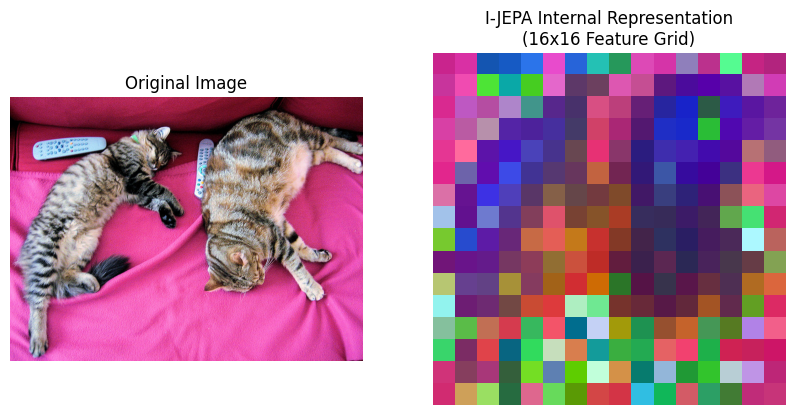

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1. Take the features from your previous step
# Shape: [1, 256, 1280] -> Remove batch dimension -> [256, 1280]
features = last_hidden_state.squeeze(0).cpu().numpy()

# 2. Apply PCA to reduce 1280 dims -> 3 dims (RGB)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)

# 3. Normalize to [0, 1] for plotting as RGB
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 4. Reshape back to a grid (14x14 patches = 196? or 16x16=256?)
# We need to calculate the grid size based on the number of patches
n_patches = features.shape[0]
side_dim = int(n_patches**0.5) # e.g., sqrt(256) = 16
feature_map = pca_features.reshape(side_dim, side_dim, 3)

# 5. Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# What I-JEPA "Sees" (PCA Visualization)
ax[1].imshow(feature_map)
ax[1].set_title(f"I-JEPA Internal Representation\n({side_dim}x{side_dim} Feature Grid)")
ax[1].axis('off')

plt.show()